# Amazon sentiment analysis: instance weighting
Data downloaded from: [processed_acl.tar.gz](https://www.cs.jhu.edu/~mdredze/datasets/sentiment/) Processed for John Blitzer, Mark Dredze, Fernando Pereira. Biographies, Bollywood, Boom-boxes and Blenders: Domain Adaptation for Sentiment Classification. Association of Computational Linguistics (ACL), 2007

Data are put in the folder named 'data'


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from read_funcs import organise_data, vectorise_data, select_high_freq_data
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
src = 'dvd'
tgt = 'kitchen'
XB, Y_src, XD, Y_tgt = organise_data(src, tgt)

dvd 1000 -1000
kitchen 1000 -1000


In [3]:
# Vectorise the raw data
X_src, X_tgt, features = vectorise_data(XB, XD)
# Reduce the no. of features
N = 10000
X_src, X_tgt, features = select_high_freq_data(X_src, X_tgt, features, N)

In [4]:
print(features[-20:])

['about', 'his', 'great', 'out', 'very', 'like', 'just', 'if', 'film', 'all', 'so', 'they', 'my', 'movie', 'one', '<num>', 'not', 'you', 'was', 'i']


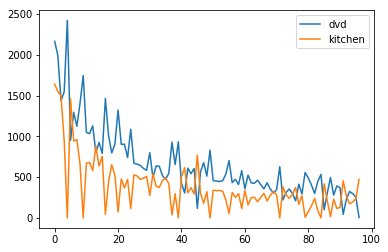

In [5]:
# Visualise the difference in the frequent features
B_count = np.sum(X_src,0)
D_count = np.sum(X_tgt,0)
plt.plot(B_count[-3:-100:-1])
plt.plot(D_count[-3:-100:-1])
plt.legend([src, tgt])

In [6]:
# Base case
model = LogisticRegression(C = 1) # Regularisation parameter C = 1
model.fit(X_src, Y_src)
print('train {:s} acc: {:.3f}, test {:s} acc: {:.3f}'\
      .format(src, model.score(X_src, Y_src), tgt, model.score(X_tgt,Y_tgt)))

train dvd acc: 1.000, test kitchen acc: 0.774


In [7]:
# Test the sensitivity to regularisation parameter
C_test = np.linspace(0.1,2,20)
acc_train = []
acc_dev = []
for C in C_test:
    model_BL = LogisticRegression(C = C) 
    model_BL.fit(X_src, Y_src)
    acc_train.append(model_BL.score(X_src, Y_src))
    acc_dev.append(model_BL.score(X_tgt, Y_tgt))

optimal alpha 1.1 train acc 1.0 max acc 0.7755


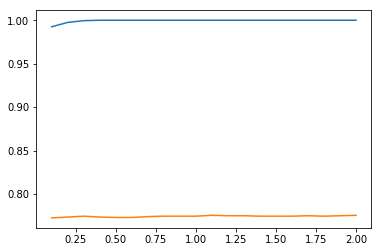

In [8]:
C_opt = C_test[np.argmax(acc_dev)]
model_BL = LogisticRegression(C = C_opt) 
model_BL.fit(X_src, Y_src)
print('optimal alpha', C_opt, 'train acc', model_BL.score(X_src, Y_src), 'max acc', max(acc_dev))
plt.plot(C_test, acc_train)
plt.plot(C_test, acc_dev)

In [9]:
C_opt = 1
model_BL = LogisticRegression(C = C_opt) 
model_BL.fit(X_src, Y_src)
print('Baseline', C_opt, 'train acc', model.score(X_src, Y_src), 'max acc', max(acc_dev))

Baseline 1 train acc 1.0 max acc 0.7755


# Instance weighting: $\alpha$

Weight each example using $\frac{P_t(x^s_i)}{P_s(x^s_i)}$

In [12]:
def mean_error_fixed_size_alpha(X_s, X_t, Y_s, Y_t):
    Ns = np.size(X_s,0)
    err_alpha = []
    X_scr_tgt = np.r_[X_s, X_t]
    # Build the classifier for source VS target
    Y_scr_tgt = np.r_[np.zeros(np.size(X_s,0)),np.ones(np.size(X_t,0))]
    model_src_tgt = LogisticRegression(C = 1)
    model_src_tgt.fit(X_scr_tgt, Y_scr_tgt)
    # This model is P(target|x), from which we can estimate alpha
    p_src_tgt = model_src_tgt.predict_proba(X_s)
    alpha_initial = p_src_tgt[:,1]/p_src_tgt[:,0]
    plt.hist(alpha_initial, bins = 20)
    C = np.sum(alpha_initial)
    alpha = alpha_initial/C*Ns
    # Weight each sample with alpha
    model = LogisticRegression(C = 1)
    model.fit(X_s,Y_s,alpha)
    print('baseline src only:', model.score(X_t, Y_t))

test dvd to kitchen with alpha weighting
baseline src only: 0.749


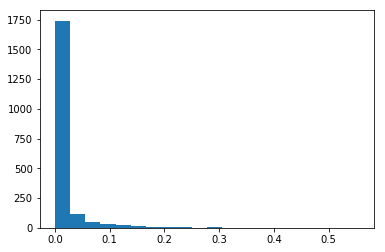

In [13]:
print('test {} to {} with alpha weighting'.format( src, tgt))
mean_error_fixed_size_alpha(X_src, X_tgt, Y_src, Y_tgt)

## Semi-supervised learning
Semi-supervised learning with a small number of labeled target data.

Models
- Baseline with source only
- $\beta$ weighting using a model trained on the labeled target data: $\beta = \frac{P_t(y^s_i|x^s_i)}{P_s(y^s_i|x^s_i)}$
- baseline with source + labeled target data
- source + labeled target data + beta weighting
- source + up-weighted labeled target data

In [14]:
def compute_beta(model_BL, model_tgt_labeled, X_s, Y_s):
    selection = [[True, False],[False,True]]
    idx = [selection[i] for i in Y_s]
    idx = []
    for i in Y_s:
        if i == 1:
            idx.append(selection[1])
        else:
            idx.append(selection[0])
    prob_tgt = model_tgt_labeled.predict_proba(X_s)
    prob_tgt = prob_tgt[idx]
    prob_BL = model_BL.predict_proba(X_s)
    prob_BL = prob_BL[idx]
    beta_initial = prob_tgt/prob_BL
    return beta_initial

In [15]:
def mean_error_fixed_size(X_s, X_t, Y_s, Y_t, test_size, Nrepeat):
    Ns = np.size(X_s,0)
    err_BL = []
    err_BL2 = []
    err_BAL = []
    err_beta = []
    err_beta2 = []
    n_t_l = test_size
    for i in range(Nrepeat):
        # get labeled target data
        X_tu, X_tl, Y_tu, Y_tl = train_test_split(X_t, Y_t, test_size = test_size, random_state = i)
        X_train_full = np.r_[X_s, X_tl]
        Y_train_full = np.r_[Y_s, Y_tl]
        
        # Baseline for source
        model_BL = LogisticRegression(C = 1)
        model_BL.fit(X_s,Y_s)
        err_BL.append(model_BL.score(X_tu, Y_tu))
        
        # beta-weighting
        model_tgt_labeled = LogisticRegression(C = 1)
        model_tgt_labeled.fit(X_tl,Y_tl)
        beta = compute_beta(model_BL, model_tgt_labeled, X_s, Y_s)
        beta = beta/np.sum(beta)*Ns
        model2_beta = LogisticRegression(C = 1)
        model2_beta.fit(X_s,Y_s,beta)
        err_beta.append(model2_beta.score(X_tu, Y_tu))

        # Baseline with target data
        model2_BL = LogisticRegression(C = 1)
        model2_BL.fit(X_train_full,Y_train_full)
        err_BL2.append(model2_BL.score(X_tu, Y_tu))
        
        # beta with labeled target data
        beta = np.r_[beta, np.ones(n_t_l)]
        model2_beta = LogisticRegression(C = 1)
        model2_beta.fit(X_train_full,Y_train_full,beta)
        err_beta2.append(model2_beta.score(X_tu, Y_tu))

        # Balanced (upweight target domain)
        weight_BAL = np.r_[np.ones(Ns), Ns/n_t_l*np.ones(n_t_l)]
        model2_BAL = LogisticRegression(C = 1)
        model2_BAL.fit(X_train_full,Y_train_full, weight_BAL)
        err_BAL.append(model2_BAL.score(X_tu, Y_tu))

#         print('iter: {:d}, BL train acc: {:.3f}, test acc: {:.3f}'\
#               .format(i+1, model2_BL.score(X_train_full,Y_train_full), err_BL[-1]))
#         print('BAL train acc: {:.3f}, test acc: {:.3f}'\
#               .format(model2_BAL.score(X_train_full,Y_train_full), err_BAL[-1]))
#         print('beta train acc: {:.3f}, test acc: {:.3f}'\
#               .format(model2_beta.score(X_train_full,Y_train_full), err_beta[-1]))
    np.set_printoptions(precision=3)
    print('baseline src only:', np.asarray(err_BL))
    print('beta weighting', np.asarray(err_beta))
    print('baseline src + lt', np.asarray(err_BL2))
    print('src + lt + beta', np.asarray(err_beta2))
    print('upweighted tgt domain', np.asarray(err_BAL))
    return [np.mean(err_BL), np.mean(err_beta), np.mean(err_BL2), \
            np.mean(err_beta2), np.mean(err_BAL)]

In [16]:
test_size = 80
Nrepeat = 8
full_results = []
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test dvd to kitchen with labeled target size 80
baseline src only: [ 0.775  0.773  0.771  0.773  0.772  0.772  0.776  0.774]
beta weighting [ 0.783  0.768  0.767  0.786  0.786  0.774  0.785  0.773]
baseline src + lt [ 0.8    0.778  0.792  0.783  0.793  0.792  0.799  0.801]
src + lt + beta [ 0.805  0.783  0.792  0.799  0.798  0.799  0.801  0.802]
upweighted tgt domain [ 0.819  0.786  0.803  0.798  0.801  0.8    0.792  0.809]


In [17]:
test_size = 120
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test dvd to kitchen with labeled target size 120
baseline src only: [ 0.775  0.773  0.769  0.774  0.77   0.771  0.773  0.776]
beta weighting [ 0.786  0.782  0.77   0.788  0.786  0.781  0.793  0.779]
baseline src + lt [ 0.809  0.794  0.791  0.8    0.794  0.798  0.811  0.812]
src + lt + beta [ 0.814  0.798  0.797  0.811  0.798  0.803  0.822  0.823]
upweighted tgt domain [ 0.818  0.794  0.811  0.814  0.807  0.812  0.822  0.824]


In [18]:
test_size = 200
print('test {} to {} with labeled target size {}'.format( src, tgt, test_size))
full_results.append(mean_error_fixed_size(X_src, X_tgt, Y_src, Y_tgt, test_size, Nrepeat))

test dvd to kitchen with labeled target size 200
baseline src only: [ 0.777  0.772  0.77   0.777  0.77   0.77   0.772  0.774]
beta weighting [ 0.792  0.787  0.774  0.793  0.788  0.786  0.786  0.787]
baseline src + lt [ 0.821  0.81   0.816  0.809  0.809  0.809  0.818  0.832]
src + lt + beta [ 0.819  0.811  0.813  0.816  0.819  0.813  0.817  0.836]
upweighted tgt domain [ 0.826  0.814  0.824  0.813  0.819  0.813  0.829  0.832]


In [20]:
results_summary = np.asarray(full_results)
results_summary.shape

(3, 5)

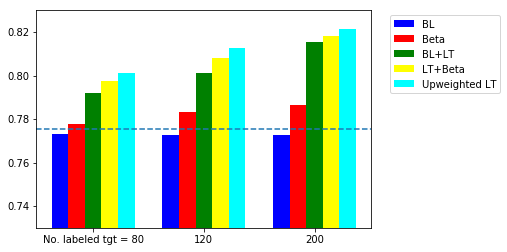

In [33]:
index = np.array([1, 2, 3])
bar_width = 0.15
color_list = ['blue','red', 'green', 'yellow','cyan']
label_list = ['BL', 'Beta', 'BL+LT', 'LT+Beta', 'Upweighted LT']
for i in range(5):
    plt.bar(index + i*bar_width, results_summary[:,i], bar_width, \
            color = color_list[i], label = label_list[i])
plt.xticks(index + 2*bar_width, ('No. labeled tgt = 80','120', '200' ))
plt.ylim(0.73,0.83)
plt.axhline(y = 0.7755, ls = '--')
plt.legend(bbox_to_anchor=(1.4, 1.0))
plt.savefig("AccSemiSup_{}_to_{}.png".format(src,tgt), bbox_inches="tight")